## **Skin Cancer Classification using Transfer Learning**

Pre-Trained Model used - ResNet18

In [10]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# chekcing if CUDA is available
torch.cuda.is_available()

True

In [12]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# Set up path for data after downloading
train_dir = "./data/train/"
test_dir = "./data/test/"
train_classa_dir = "./data/train/benign/"
train_classb_dir = "./data/train/malignant/"
test_classa_dir = "./data/test/benign/"
test_classb_dir = "./data/test/malignant/"

This is benign skin cancer


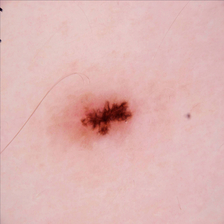

In [14]:
# Loading an image
img = torchvision.io.read_image(f'{test_classa_dir}1.jpg')
print("This is benign skin cancer")
T.ToPILImage()(img)

This is malignant skin cancer


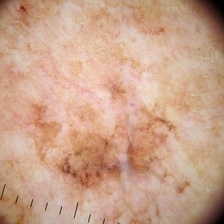

In [15]:
# Loading an image
img = torchvision.io.read_image(f'{test_classb_dir}1.jpg')
print("This is malignant skin cancer")
T.ToPILImage()(img)

#### **Data Preprocessing**

In [16]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])
])

In [17]:
# Apply transformations to train & test data

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [18]:
print(f'Train Dataset Size: {len(train_dataset)}')
print(f'Test Dataset Size: {len(test_dataset)}')

class_names = train_dataset.classes
print(f'Classe Names: {class_names}')

Train Dataset Size: 2077
Test Dataset Size: 660
Classe Names: ['benign', 'malignant']


#### **Data Visualization**

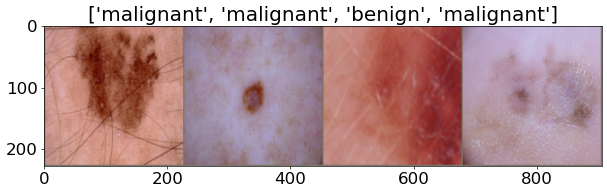

In [19]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input, title):
    input = input.numpy().transpose((1, 2, 0))  # tensor to numpy
    
    # reverse normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    # display images
    
    plt.imshow(input)
    plt.title(title)
    plt.show()

# load a training batch
iterator = iter(train_dataloader)

inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

#### **Loading a pre-trained model**

In [52]:
# loading model from torch
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
num_features = model.fc.in_features
print(f'Number of features from pre-trained model: {num_features}')

Number of features from pre-trained model: 512


In [54]:
# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#### **Model Training**

In [56]:
lr = 0.0001
momentum = 0.9

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# saving loss in a list for later use
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

num_epochs = 35
start_time = time.time()

for epoch in range(num_epochs):
    print(f'\n{epoch+1}{"st" if str(epoch+1)[-1] in "1" else "nd" if str(epoch+1) in "2" else "rd" if str(epoch+1) in "3" else "th"} epoch running:')
    
    ### Training Phase ###
    model.train()
    running_loss = 0
    running_corrects = 0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)     # Generating Output
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)   # Calculating Loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    
    # Calculating epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    
    # Appending train resutls
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    
    # Printing progress
    print(f'[Train {epoch+1}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}% Time: {time.time() -start_time}s')
    
    
    ### Testing Phase ###
    model.eval()
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        
        # Appending test result
        test_loss.append(epoch_loss)
        test_accuracy.append(epoch_acc)
        
        # Printing progress
        print(f'[Test {epoch+1}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}% Time: {time.time() -start_time}s')


1st epoch running:
[Train 1] Loss: 0.0443 Acc: 72.8936% Time: 17.043911933898926s
[Test 1] Loss: 0.0369 Acc: 78.4848% Time: 19.930906057357788s

2nd epoch running:
[Train 2] Loss: 0.0369 Acc: 79.6822% Time: 34.561906814575195s
[Test 2] Loss: 0.0345 Acc: 77.7273% Time: 37.31392478942871s

3rd epoch running:
[Train 3] Loss: 0.0342 Acc: 80.4526% Time: 52.10390615463257s
[Test 3] Loss: 0.0313 Acc: 82.1212% Time: 54.95491313934326s

4th epoch running:
[Train 4] Loss: 0.0341 Acc: 81.3674% Time: 70.04790616035461s
[Test 4] Loss: 0.0299 Acc: 83.3333% Time: 72.9579062461853s

5th epoch running:
[Train 5] Loss: 0.0328 Acc: 82.4266% Time: 88.32291722297668s
[Test 5] Loss: 0.0307 Acc: 82.4242% Time: 91.24291586875916s

6th epoch running:
[Train 6] Loss: 0.0310 Acc: 83.2932% Time: 106.6979148387909s
[Test 6] Loss: 0.0295 Acc: 82.8788% Time: 109.61591291427612s

7th epoch running:
[Train 7] Loss: 0.0304 Acc: 82.4266% Time: 125.36190605163574s
[Test 7] Loss: 0.0289 Acc: 82.7273% Time: 128.4079108238

#### **Saving the Model**

In [60]:
save_path = 'skin_cancer_classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

In [48]:
# model.load_state_dict(torch.load('skin_cancer_classifier_resnet_18_final.pth'))
# model.eval()

#### **Model Evaluation**

Let us compare training and testing accuracy over time

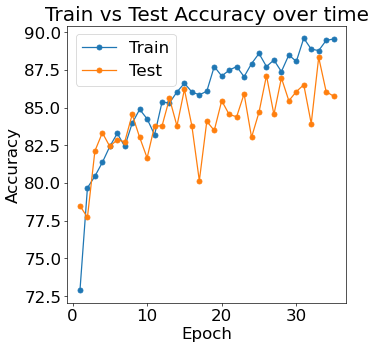

In [57]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(1, num_epochs+1), train_accuracy, '-o')
plt.plot(np.arange(1, num_epochs+1), test_accuracy, '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

Next, let us check the performance for each class

In [61]:
y_pred = []
y_true = []

num_epochs = 30
start_time = time.time()
for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)     # Model Predictions
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)      # Saving outputs
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)       # Saving true labels


classes = test_dataset.classes
print(f'Accuracy on Training Set: {accuracy_score(y_true, y_pred):.4f}')
print(f'Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}')
print(f'Classification Report: \n{classification_report(y_true, y_pred)}')

Accuracy on Training Set: 0.8335
Confusion Matrix: 
[[10013   787]
 [ 2509  6491]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     10800
           1       0.89      0.72      0.80      9000

    accuracy                           0.83     19800
   macro avg       0.85      0.82      0.83     19800
weighted avg       0.84      0.83      0.83     19800



<Axes: title={'center': 'Confusion matrix for Skin Cancer Classification'}>

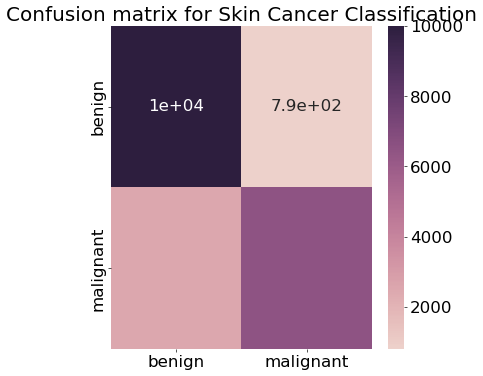

In [62]:
cf_matrix = confusion_matrix(y_true, y_pred)
class_list = [i for i in classes]
df_cm = pd.DataFrame(cf_matrix, index=class_list, columns=class_list)
plt.figure(figsize=(7,7))
plt.title('Confusion matrix for Skin Cancer Classification')
sn.heatmap(df_cm, annot=True, cmap=sn.cubehelix_palette(as_cmap=True))

##### <center> Notebook ends here </center>

---

Further Steps -
- Creting File Structure
- Create train.py
- Create utils.py
- Create main.py
- Model Deployment